## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-06-02 23:26:03.872 | INFO     |  Running on cpu


In [3]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'OpenDrawer'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


2025-06-02 23:26:10.949 | INFO     |  Loading dataset(s): 
2025-06-02 23:26:10.951 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/OpenDrawer/demos/metadata.json
2025-06-02 23:26:10.952 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-06-02 23:26:10.953 | INFO     |    Extracted tsdf object labels []
2025-06-02 23:26:10.953 | INFO     |    Done! Data contains 4 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torc

In [4]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([144, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([144]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([144, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([144, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([144, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([144, 3, 256, 256]), device=cpu, dt

In [6]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2, # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation
    drop_redundant_frames=True,

)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.001,
    components_prop_to_len=True,
    min_end_distance=2,
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-06-02 23:26:22.800 | INFO     |  Fitting AutoTPGMM
2025-06-02 23:26:22.801 | INFO     |  Performing fitting actions: [INIT]
2025-06-02 23:26:22.801 | INFO     |  Segmenting trajectories


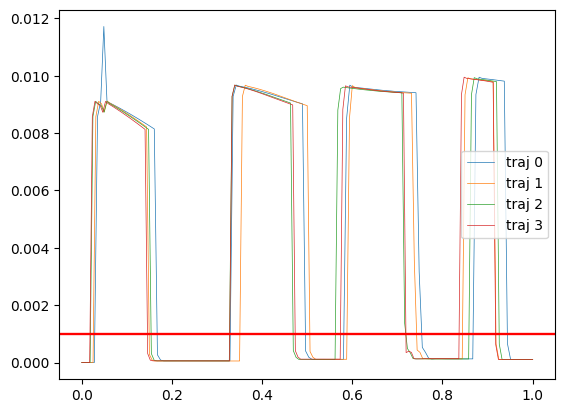

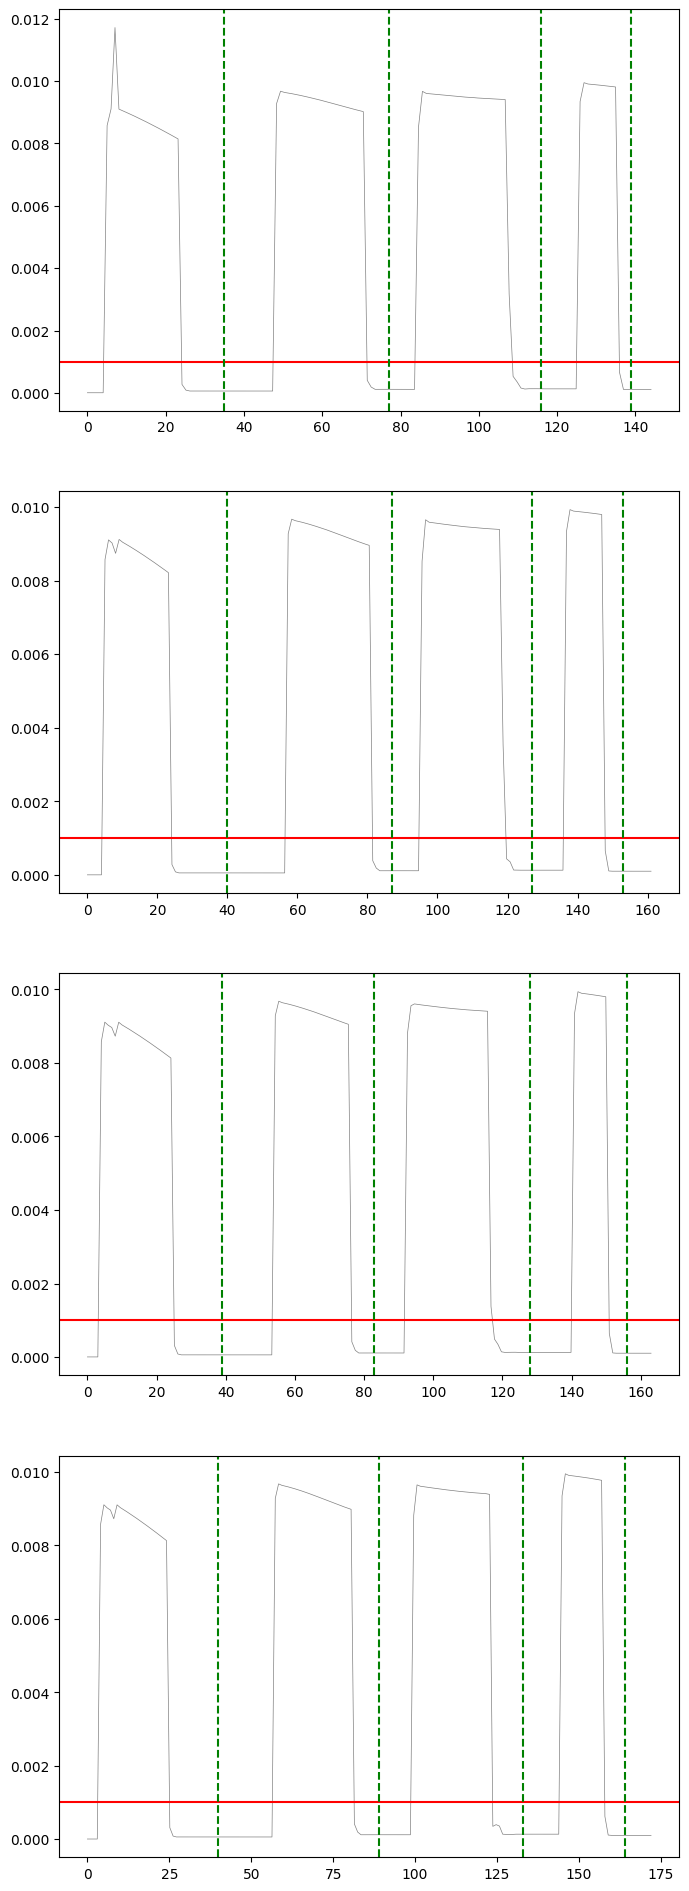

2025-06-02 23:26:25.340 | INFO     |  Creating segement of demos.
2025-06-02 23:26:25.367 | INFO     |  Subsampling to length 47 using strategy mean-length.
2025-06-02 23:26:25.370 | INFO     |  Creating segement of demos.
2025-06-02 23:26:25.395 | INFO     |  Subsampling to length 54 using strategy mean-length.
2025-06-02 23:26:25.400 | INFO     |  Creating segement of demos.
2025-06-02 23:26:25.428 | INFO     |  Subsampling to length 51 using strategy mean-length.
2025-06-02 23:26:25.432 | INFO     |  Creating segement of demos.
2025-06-02 23:26:25.456 | INFO     |  Subsampling to length 36 using strategy mean-length.
2025-06-02 23:26:25.458 | INFO     |  Creating segement of demos.
2025-06-02 23:26:25.484 | INFO     |  Subsampling to length 16 using strategy mean-length.
2025-06-02 23:26:25.487 | INFO     |  ... created 5 segments
2025-06-02 23:26:25.487 | INFO     |    Fitting candidate frame 1/10
2025-06-02 23:26:25.489 | INFO     |    Creating partial frame view of demos.
2025-06

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:25.908 | INFO     |    Fitting candidate frame 2/10
2025-06-02 23:26:25.912 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:26.318 | INFO     |    Fitting candidate frame 3/10
2025-06-02 23:26:26.319 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:26.941 | INFO     |    Fitting candidate frame 4/10
2025-06-02 23:26:26.942 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:27.198 | INFO     |    Fitting candidate frame 5/10
2025-06-02 23:26:27.200 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:27.502 | INFO     |    Fitting candidate frame 6/10
2025-06-02 23:26:27.503 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:27.810 | INFO     |    Fitting candidate frame 7/10
2025-06-02 23:26:27.811 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:28.085 | INFO     |    Fitting candidate frame 8/10
2025-06-02 23:26:28.086 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:28.596 | INFO     |    Fitting candidate frame 9/10
2025-06-02 23:26:28.600 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:29.128 | INFO     |    Fitting candidate frame 10/10
2025-06-02 23:26:29.129 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:29.469 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-06-02 23:26:29.470 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-06-02 23:26:29.470 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-06-02 23:26:29.471 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-06-02 23:26:29.471 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-06-02 23:26:29.471 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-06-02 23:26:29.471 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-06-02 23:26:29.472 | INFO     |  obj006     score (rel):     -0 (0.000)
2025-06-02 23:26:29.472 | INFO     |  obj007     score (rel):     -0 (0.000)
2025-06-02 23:26:29.472 | INFO     |  obj008     score (rel):     -0 (0.000)
2025-06-02 23:26:29.472 | INFO     |  Dropping redundant frames [1 2 3 4 5 6].
2025-06-02 23:26:29.473 | INFO     |  Creating partial frame view of demos.
2025-06-02 23:26:29.477 | INFO     |    Fitting candidate frame 1/10
2025-0

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:29.776 | INFO     |    Fitting candidate frame 2/10
2025-06-02 23:26:29.776 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:30.092 | INFO     |    Fitting candidate frame 3/10
2025-06-02 23:26:30.093 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:30.827 | INFO     |    Fitting candidate frame 4/10
2025-06-02 23:26:30.828 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:31.372 | INFO     |    Fitting candidate frame 5/10
2025-06-02 23:26:31.372 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:31.684 | INFO     |    Fitting candidate frame 6/10
2025-06-02 23:26:31.686 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:32.059 | INFO     |    Fitting candidate frame 7/10
2025-06-02 23:26:32.060 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:32.366 | INFO     |    Fitting candidate frame 8/10
2025-06-02 23:26:32.367 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:32.924 | INFO     |    Fitting candidate frame 9/10
2025-06-02 23:26:32.925 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:34.010 | INFO     |    Fitting candidate frame 10/10
2025-06-02 23:26:34.015 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-02 23:26:34.834 | INFO     |  Creating partial frame view of demos.
2025-06-02 23:26:34.841 | INFO     |    Fitting candidate frame 1/10
2025-06-02 23:26:34.842 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:35.305 | INFO     |    Fitting candidate frame 2/10
2025-06-02 23:26:35.306 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:35.897 | INFO     |    Fitting candidate frame 3/10
2025-06-02 23:26:35.898 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:36.366 | INFO     |    Fitting candidate frame 4/10
2025-06-02 23:26:36.367 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:36.731 | INFO     |    Fitting candidate frame 5/10
2025-06-02 23:26:36.733 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:37.017 | INFO     |    Fitting candidate frame 6/10
2025-06-02 23:26:37.018 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:37.342 | INFO     |    Fitting candidate frame 7/10
2025-06-02 23:26:37.343 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:37.624 | INFO     |    Fitting candidate frame 8/10
2025-06-02 23:26:37.625 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:38.127 | INFO     |    Fitting candidate frame 9/10
2025-06-02 23:26:38.128 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:38.747 | INFO     |    Fitting candidate frame 10/10
2025-06-02 23:26:38.748 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:39.120 | INFO     |  Dropping redundant frames [2 3 4 5 6].
2025-06-02 23:26:39.121 | INFO     |  Creating partial frame view of demos.
2025-06-02 23:26:39.124 | INFO     |    Fitting candidate frame 1/10
2025-06-02 23:26:39.125 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:39.526 | INFO     |    Fitting candidate frame 2/10
2025-06-02 23:26:39.535 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:39.796 | INFO     |    Fitting candidate frame 3/10
2025-06-02 23:26:39.798 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:40.048 | INFO     |    Fitting candidate frame 4/10
2025-06-02 23:26:40.052 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:40.355 | INFO     |    Fitting candidate frame 5/10
2025-06-02 23:26:40.356 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:40.789 | INFO     |    Fitting candidate frame 6/10
2025-06-02 23:26:40.790 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:41.140 | INFO     |    Fitting candidate frame 7/10
2025-06-02 23:26:41.142 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:41.326 | INFO     |    Fitting candidate frame 8/10
2025-06-02 23:26:41.327 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:41.835 | INFO     |    Fitting candidate frame 9/10
2025-06-02 23:26:41.836 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:42.225 | INFO     |    Fitting candidate frame 10/10
2025-06-02 23:26:42.226 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:42.511 | INFO     |  Creating partial frame view of demos.
2025-06-02 23:26:42.519 | INFO     |    Fitting candidate frame 1/10
2025-06-02 23:26:42.520 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:42.759 | INFO     |    Fitting candidate frame 2/10
2025-06-02 23:26:42.762 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:43.030 | INFO     |    Fitting candidate frame 3/10
2025-06-02 23:26:43.031 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:43.223 | INFO     |    Fitting candidate frame 4/10
2025-06-02 23:26:43.224 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:43.344 | INFO     |    Fitting candidate frame 5/10
2025-06-02 23:26:43.345 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:43.474 | INFO     |    Fitting candidate frame 6/10
2025-06-02 23:26:43.476 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:43.677 | INFO     |    Fitting candidate frame 7/10
2025-06-02 23:26:43.686 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:44.026 | INFO     |    Fitting candidate frame 8/10
2025-06-02 23:26:44.028 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:44.432 | INFO     |    Fitting candidate frame 9/10
2025-06-02 23:26:44.433 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:44.920 | INFO     |    Fitting candidate frame 10/10
2025-06-02 23:26:44.925 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-02 23:26:45.207 | INFO     |  obj000     score (rel):     -0 (0.996)
2025-06-02 23:26:45.207 | INFO     |  obj001     score (rel):     -0 (0.996)
2025-06-02 23:26:45.207 | INFO     |  obj002     score (rel):     -0 (0.996)
2025-06-02 23:26:45.207 | INFO     |  obj003     score (rel):     -0 (0.996)
2025-06-02 23:26:45.207 | INFO     |  obj004     score (rel):     -0 (0.996)
2025-06-02 23:26:45.208 | INFO     |  obj005     score (rel):     -0 (0.996)
2025-06-02 23:26:45.211 | INFO     |  Creating partial frame view of demos.
2025-06-02 23:26:45.219 | INFO     |  Segmented trajs into 5 segments
2025-06-02 23:26:45.238 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142867 -0.142856 -0.142856 -0.142856 -0.142856 -0.142856   
Segment 1 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857 -0.142857   
Segment 2 -0.142872 -0.142855 -0.142855 -0.142855 -0.142855 -0.142855   
Segment 3 -0.142894 -0.142851 -0.142851 -0.

Fitting segments:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-02 23:26:45.282 | INFO     |  Changing number of components to 4


Time-based init:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-02 23:26:45.595 | INFO     |  Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-02 23:26:46.083 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[2.38e+013, 2.38e+013, 1.77e+013, 9.85e+012, 4.07e+012, 1.25e+012,
          1.38e+011, 2.17e+009, 2.76e+008, 3.91e+005, 3.68e+003, 6.39e+000,
          1.68e-003, 7.00e-008, 4.75e-013, 5.45e-019, 1.07e-025, 3.83e-033,
          2.56e-041, 3.33e-050, 8.64e-060, 4.67e-070, 5.44e-081, 1.42e-092,
          1.63e-095, 7.34e-108, 7.96e-121, 1.78e-124, 8.12e-128, 2.54e-131,
          5.91e-135, 1.03e-138, 1.33e-142, 1.27e-146, 9.12e-151, 4.88e-155,
          1.94e-159, 4.84e-164, 9.03e-169, 1.25e-173, 1.30e-178, 1.00e-183,
          5.75e-189, 2.46e-194, 7.84e-200, 1.86e-205, 3.30e-211, 2.38e+013,
          2.38e+013, 1.77e+013, 9.85e+012, 4.07e+012, 1.25e+012, 1.38e+011,
          2.17e+009, 5.03e+006, 3.20e+005, 3.70e+003, 6.31e+000, 2.32e-006,
          2.09e-011, 3.19e-017, 8.31e-024, 3.96e-031, 3.54e-039, 6.12e-048,
          2.12e-057, 1.53e-067, 2.36e-078, 8.23e-090, 6.63e-102, 3.61e-105,
          3.89e-108, 2.89e-111, 1.59e-114, 6.57e-118, 2.02e-121, 4.61e-125,
          7.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.INIT,))


2025-06-02 23:26:48.502 | INFO     |  Did not specify time_based, deciding automatically.
2025-06-02 23:26:49.528 | WARNING  |  Skippig NaN Gaussians.


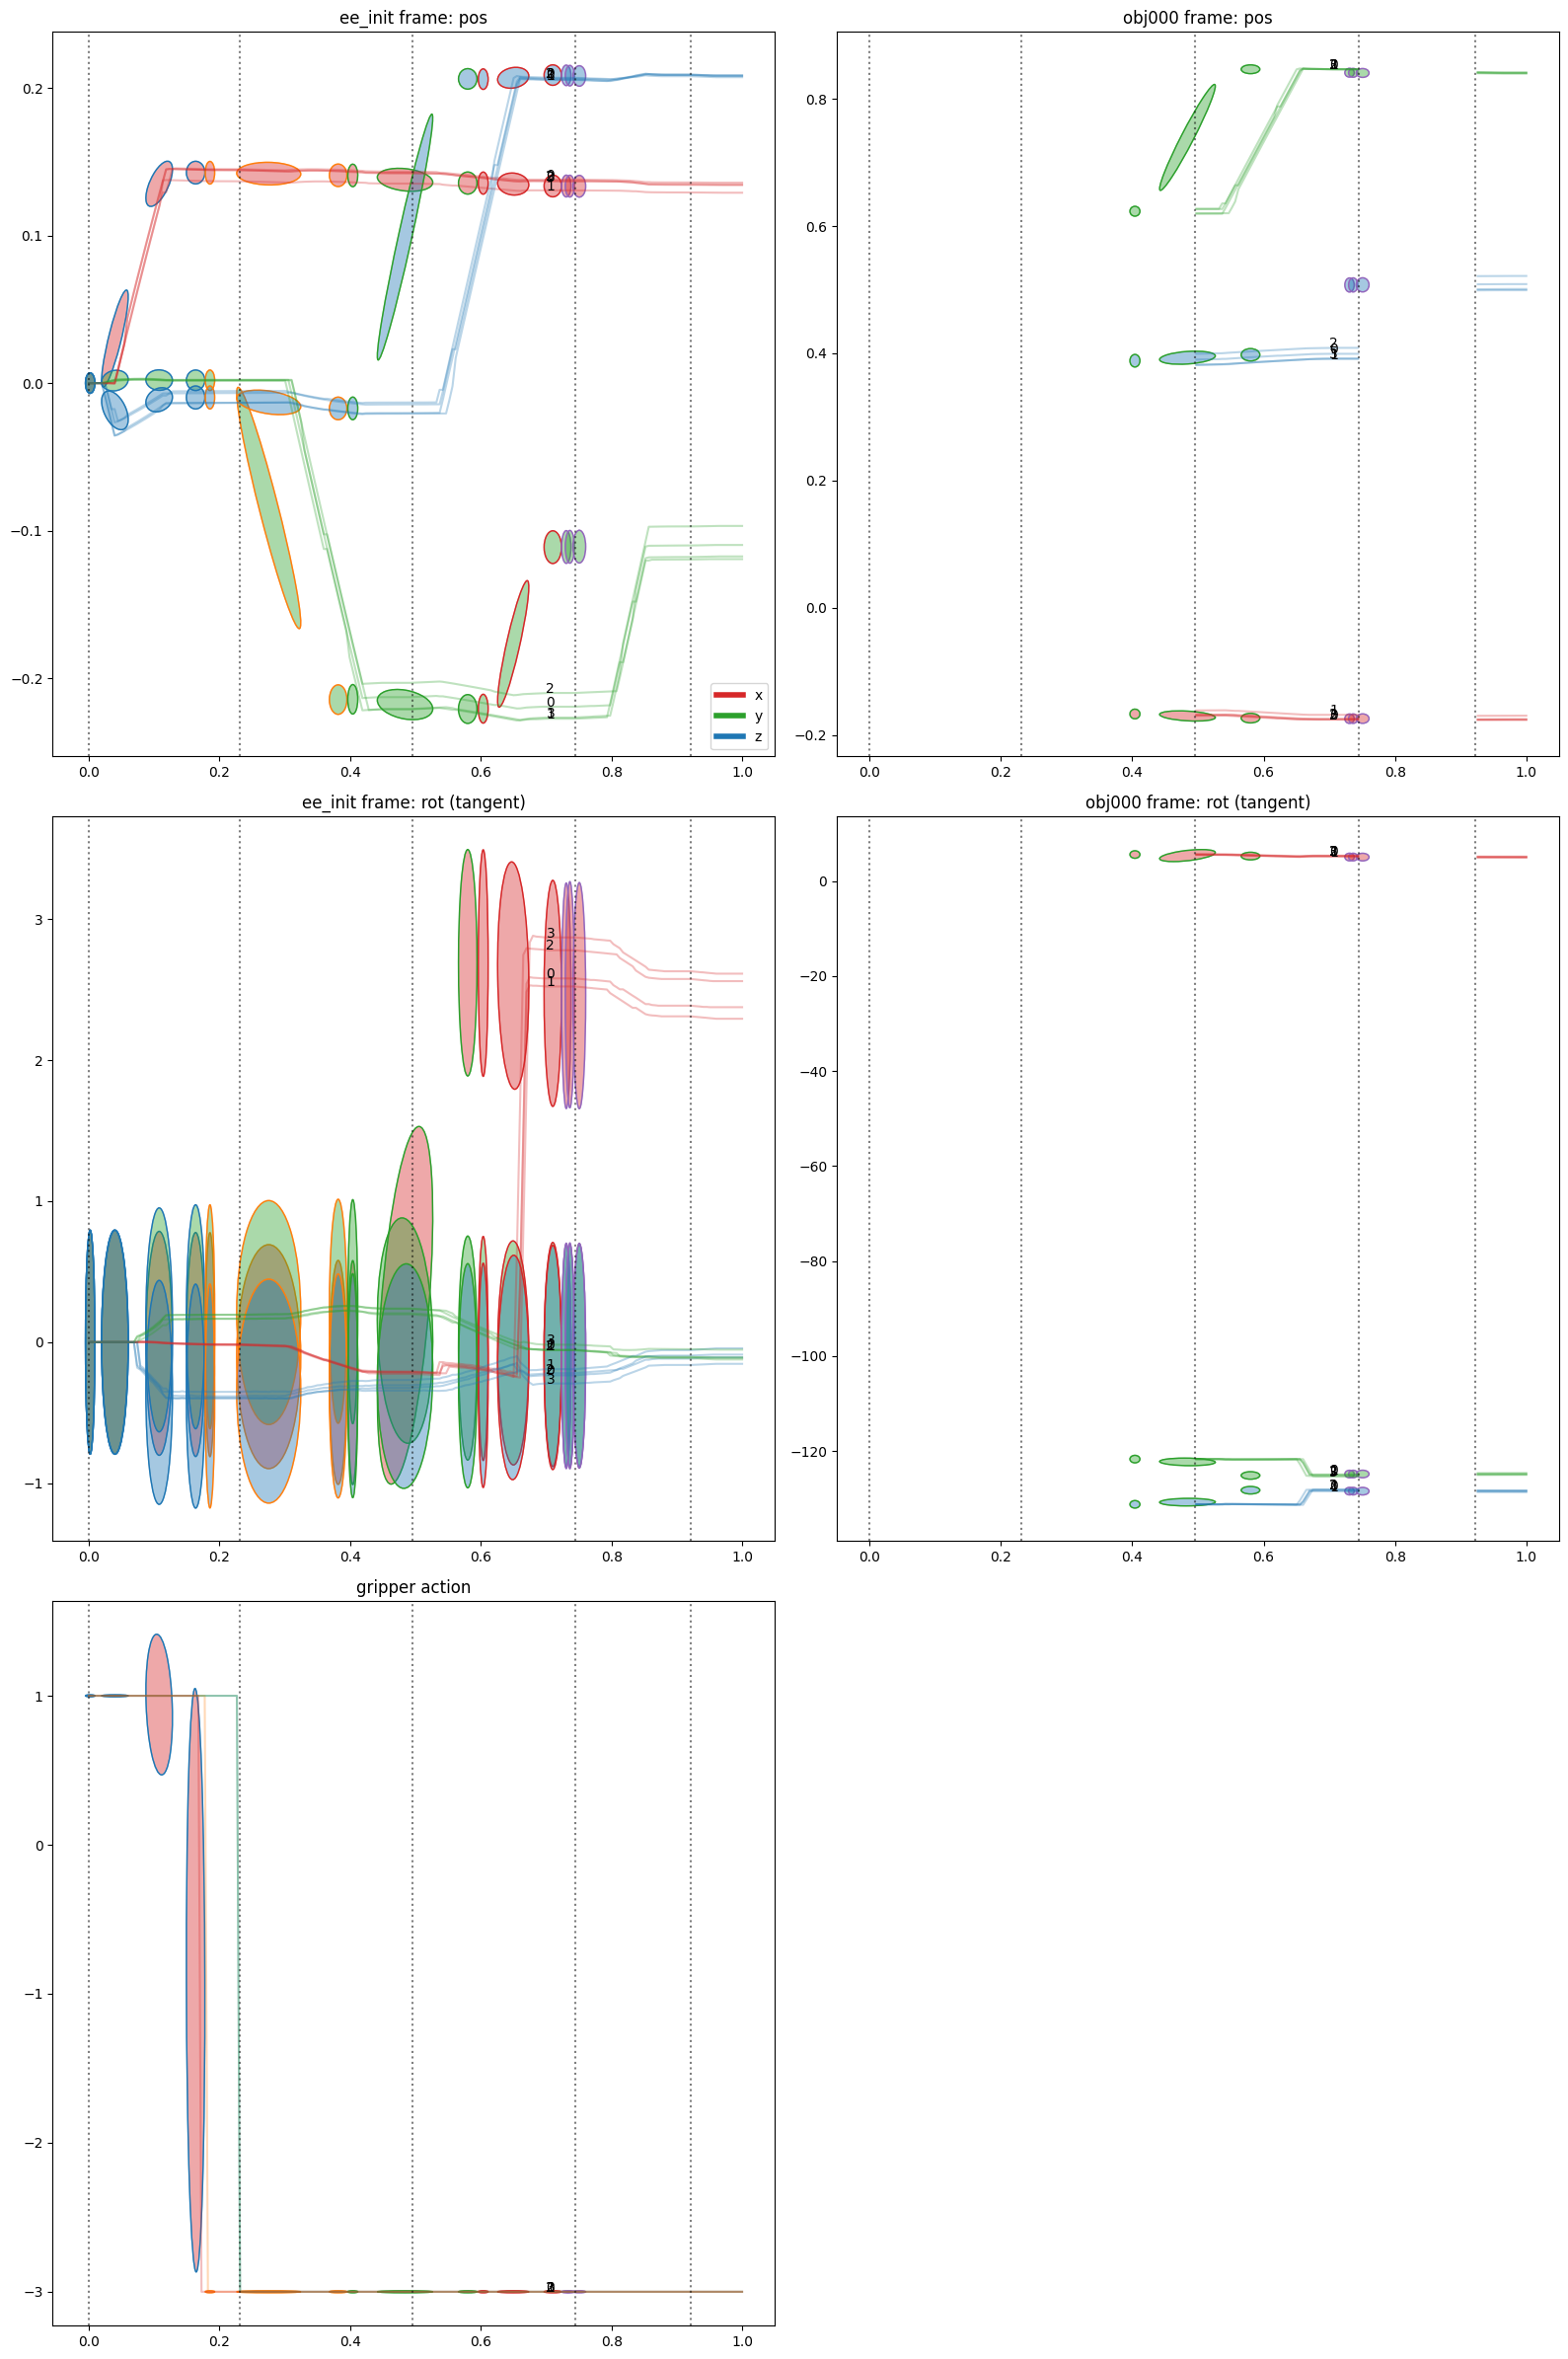

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-06-02 23:26:56.591 | INFO     |  Fitting AutoTPGMM
2025-06-02 23:26:56.591 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-02 23:26:56.609 | INFO     |  HMM EM ...
2025-06-02 23:26:56.616 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-06-02 23:26:56.702 | INFO     |  HMM init priors not defined, initializing to uniform
2025-06-02 23:27:00.743 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          9.99e-001, 7.76e-001, 1.84e-001, 4.54e-005, 8.15e-011, 2.11e-019,
          1.26e-031, 2.90e-048, 4.46e-070, 8.15e-098, 3.20e-132, 5.20e-174,
          6.69e-224, 1.11e-282, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 1.00e+000,
          1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 1.00e+000, 9.99e-001,
          7.27e-001, 3.08e-003, 6.16e-007, 1.11e-012, 2.84e-021, 2.23e-036,
          1.53e-056, 1.65e-082, 5.01e-115, 8.31e-155, 1.45e-202, 4.58e-259,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.

2025-06-02 23:27:14.780 | INFO     |  Did not specify time_based, deciding automatically.


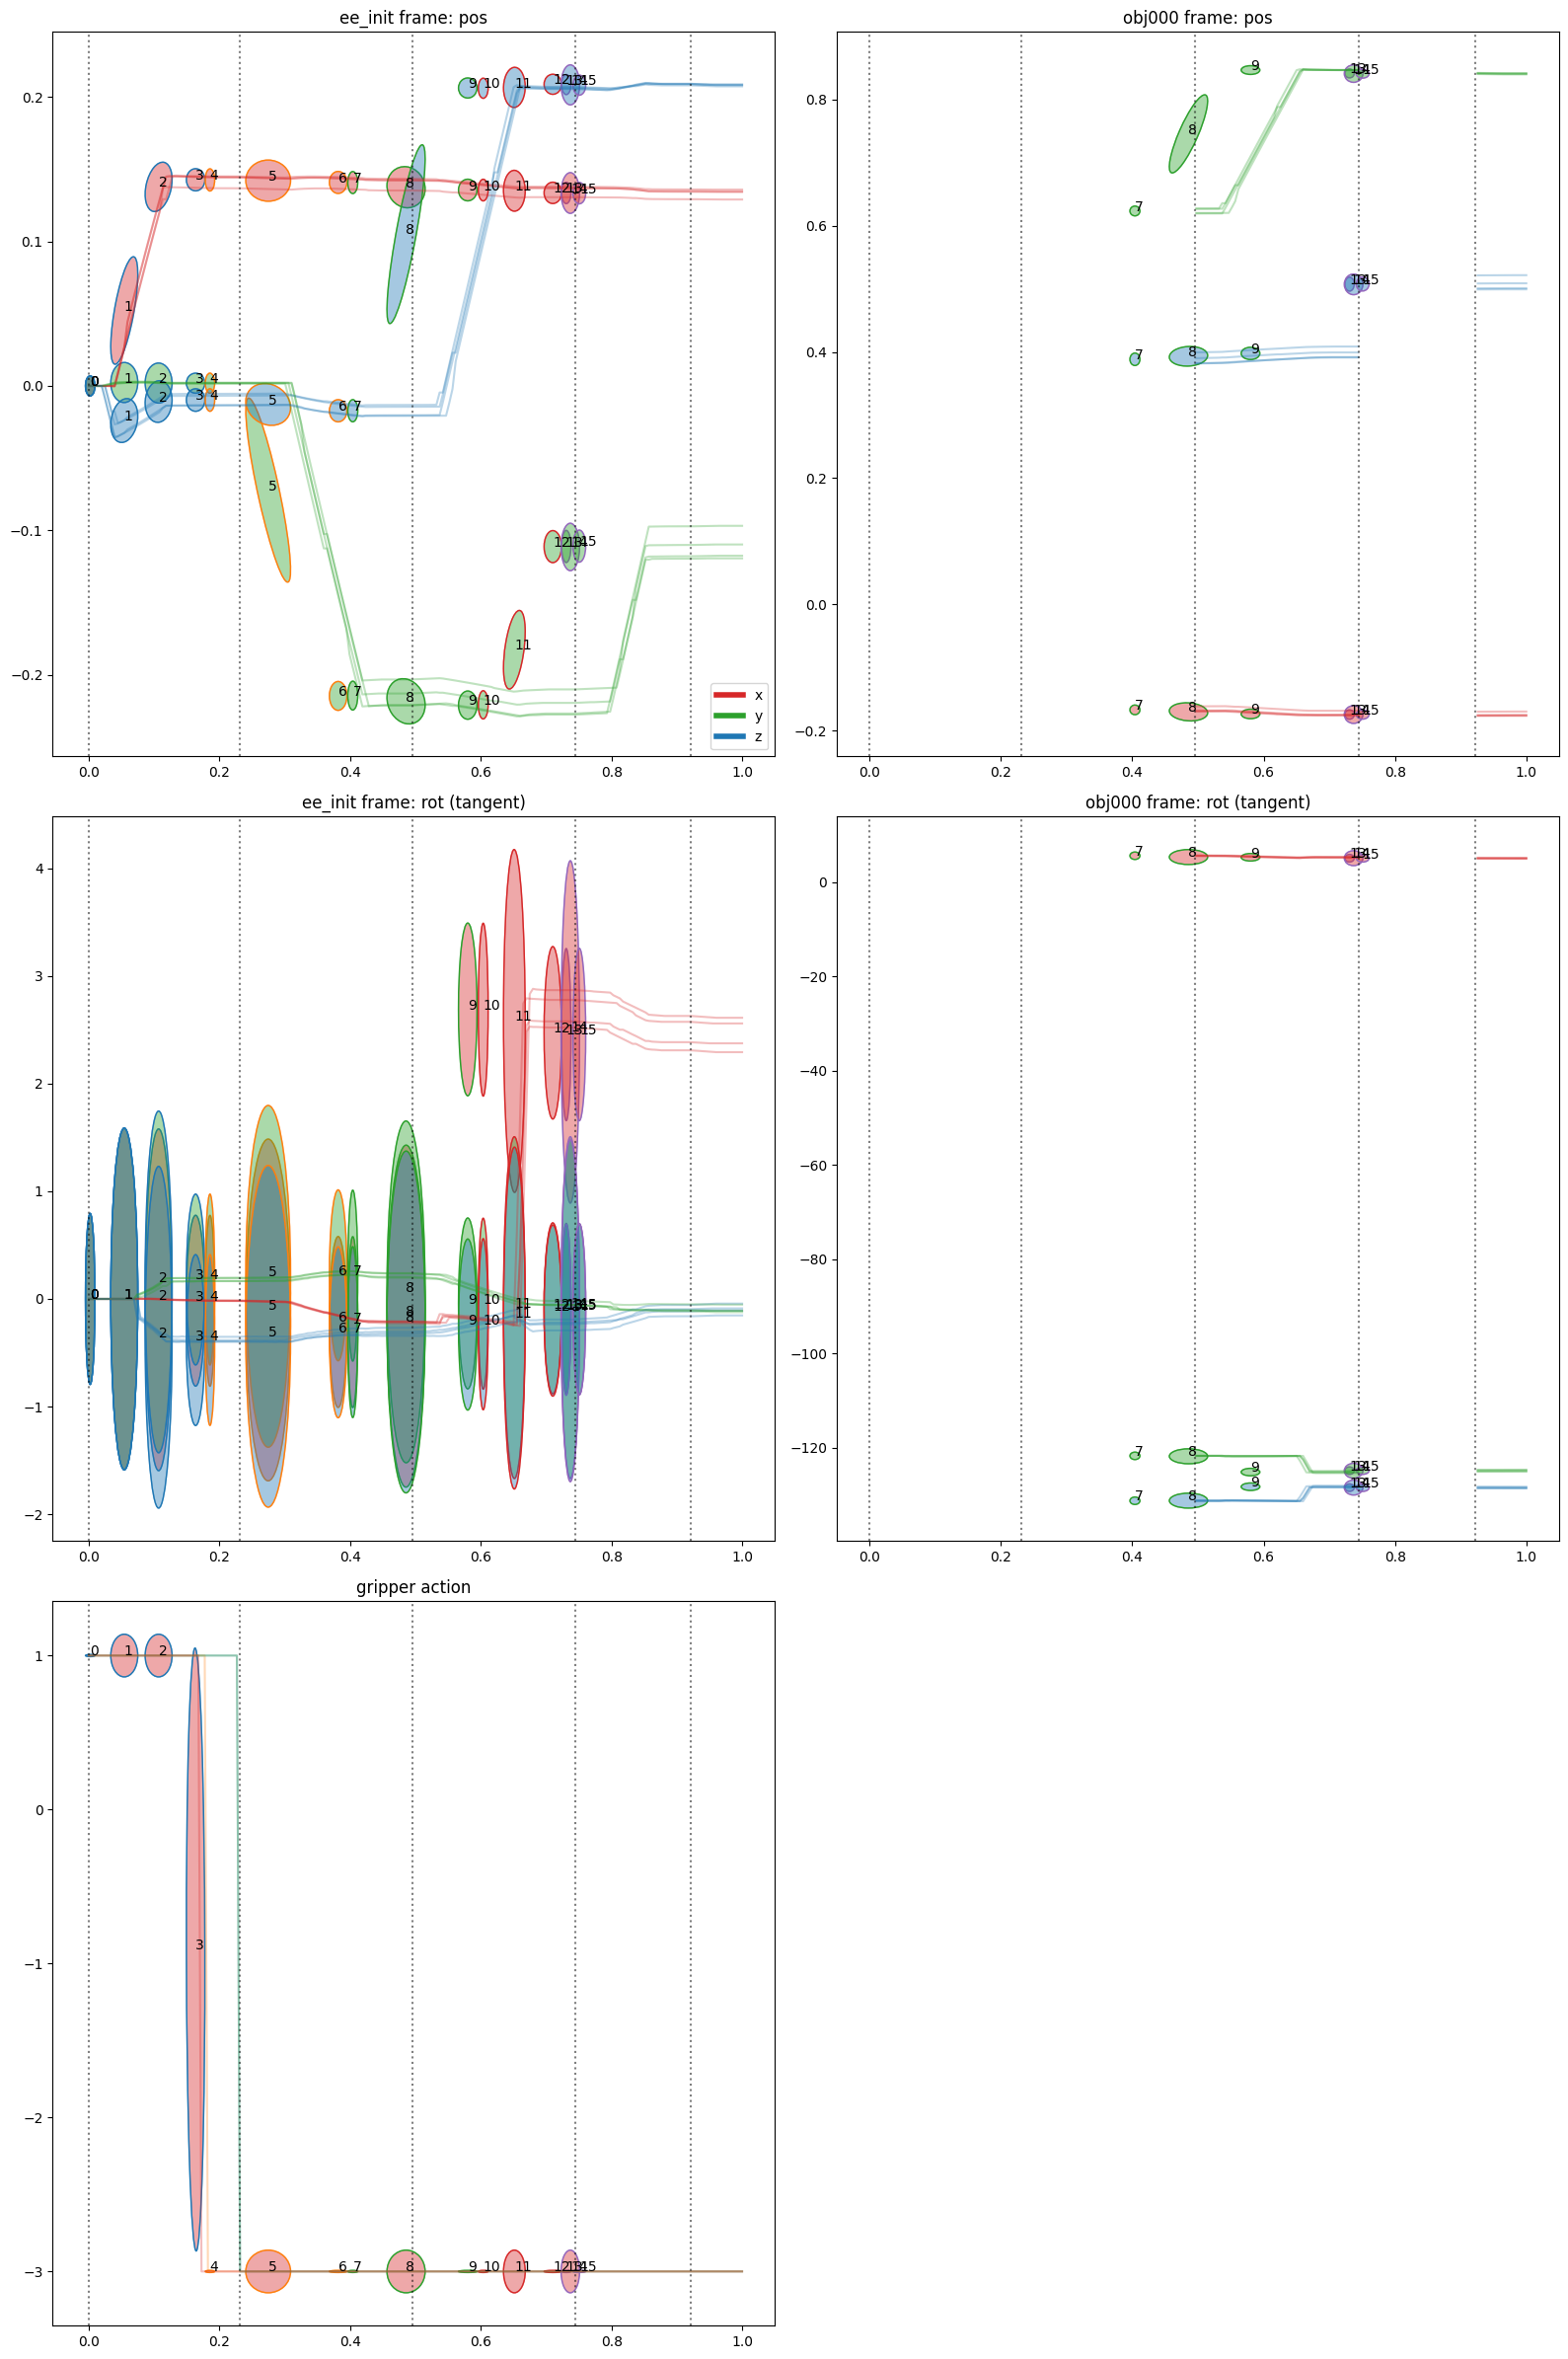

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

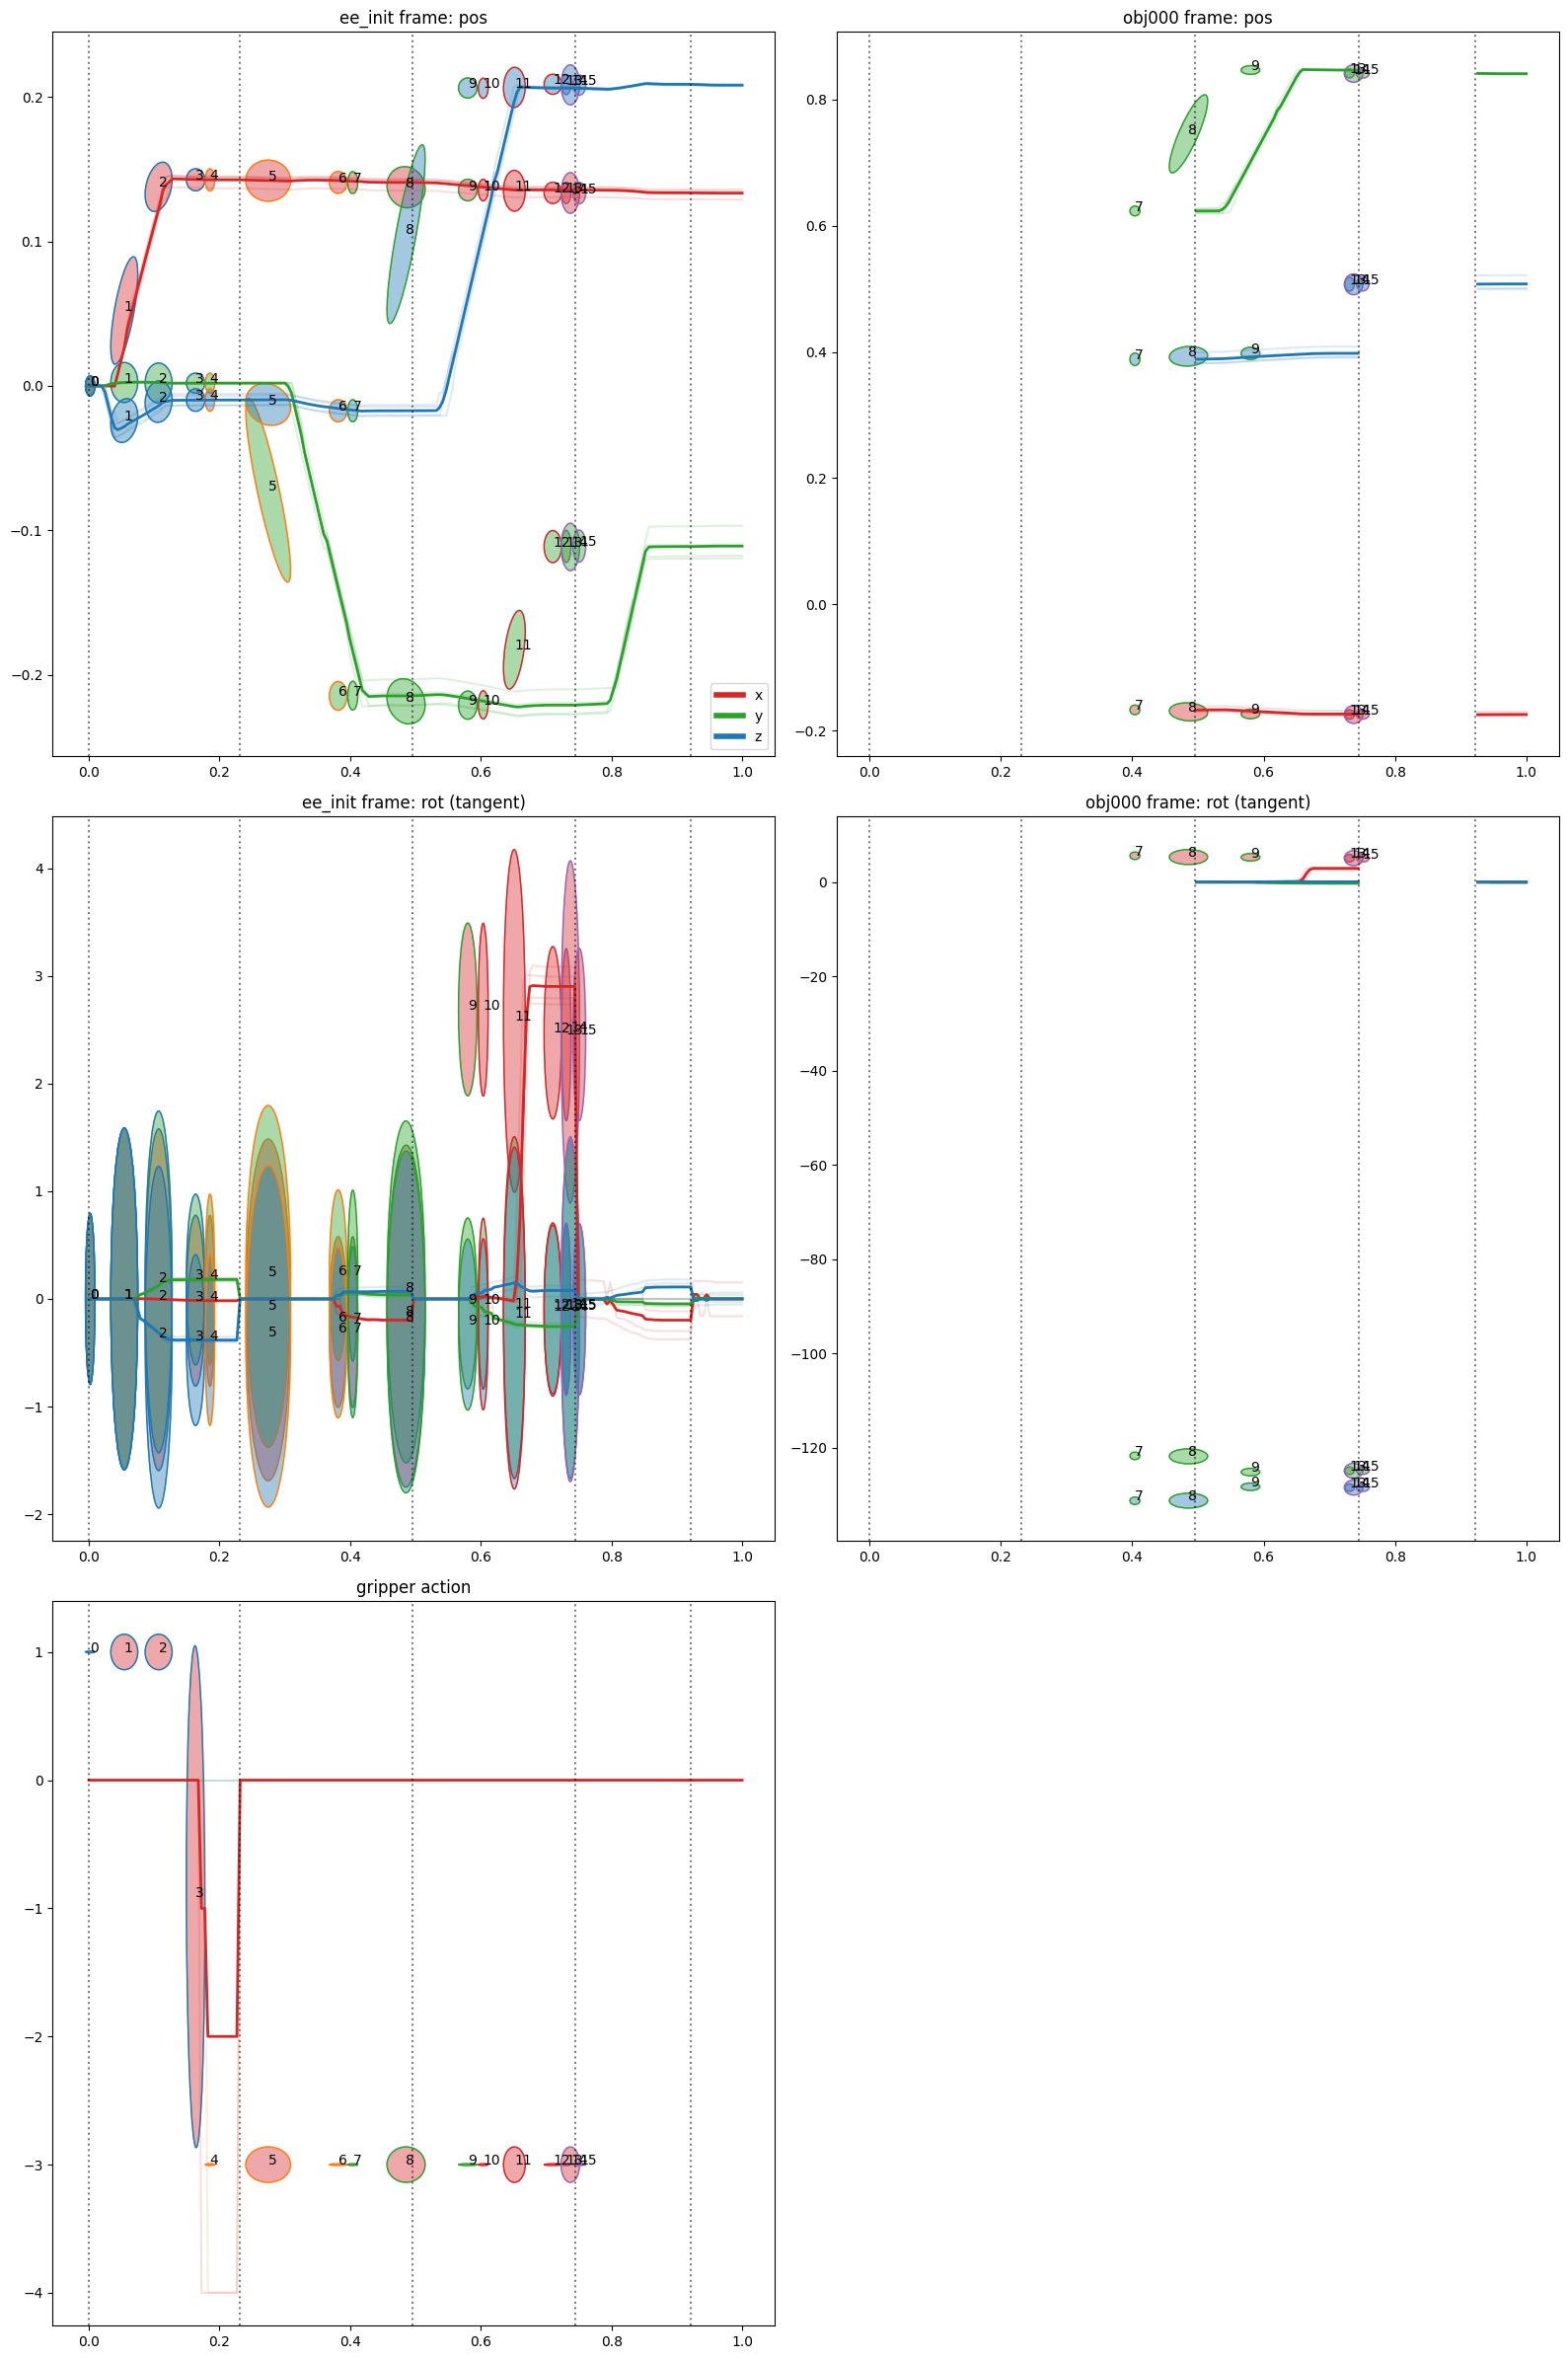

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=True, per_segment=False, gaussian_mean_only=False, plot_traj_means=True, time_based=True)

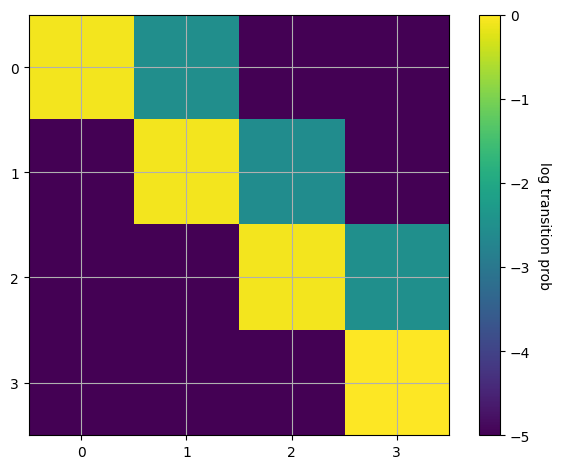

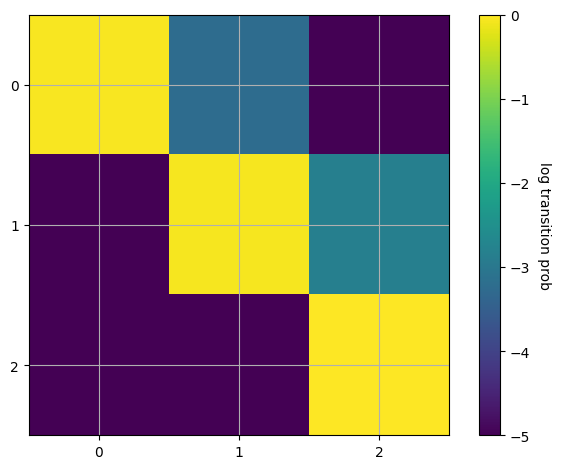

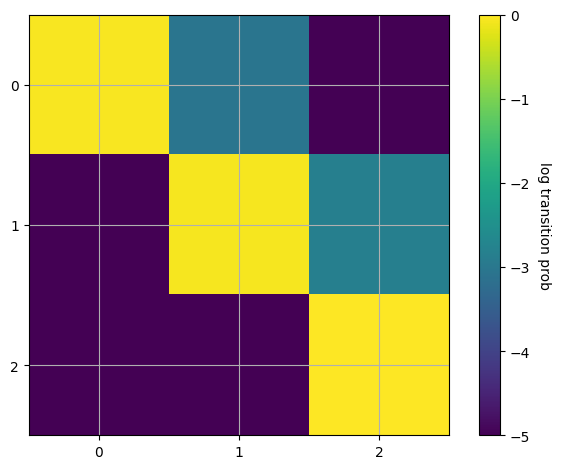

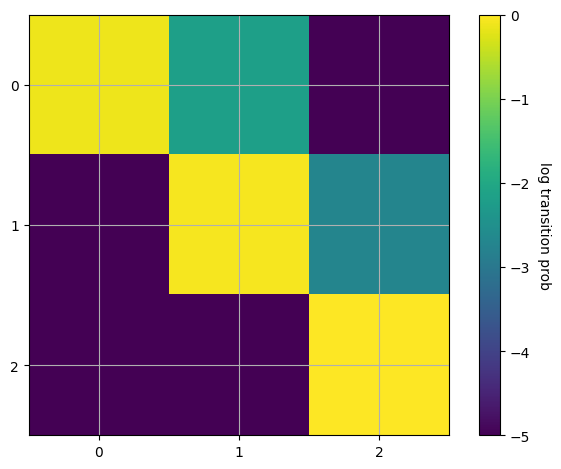

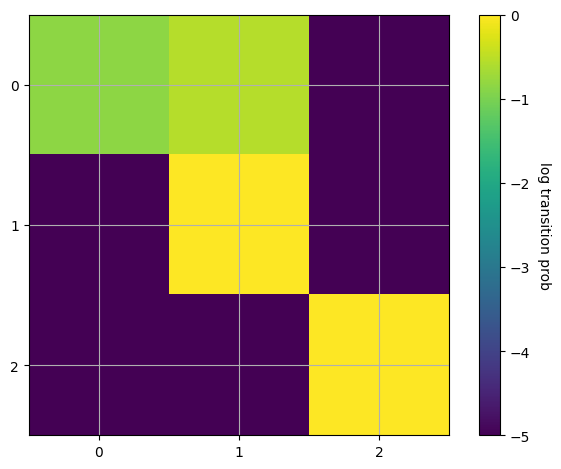

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

2025-06-02 23:27:34.515 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-06-02 23:27:35.011 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-06-02 23:29:18.139 | INFO     |  Caculated segment transition probabilities: (array([[0.01]]), array([[0.01]]), array([[0.]]), array([[0.01]]))
2025-06-02 23:29:18.140 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-06-02 23:29:18.140 | INFO     |  Creating partial frame view of demos.
2025-06-02 23:29:18.144 | INFO     |  Assuming zero frame velocity. Should be fixed.
(<riepybdlib.statistics.HMM object at 0x7ff7ac4a0f70>,)


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-02 23:29:18.227 | INFO     |  Creating partial frame view of demos.
(<riepybdlib.statistics.HMM object at 0x7ff7ac4a03d0>,)


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-02 23:29:18.287 | INFO     |  Creating partial frame view of demos.
(<riepybdlib.statistics.HMM object at 0x7ff7ac4a1270>, <riepybdlib.statistics.HMM object at 0x7ff7ac477b80>)


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-02 23:29:18.422 | INFO     |  Creating partial frame view of demos.
(<riepybdlib.statistics.HMM object at 0x7ff7a4744970>,)


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-02 23:29:18.533 | INFO     |  Creating partial frame view of demos.
(<riepybdlib.statistics.HMM object at 0x7ff7a44b1a50>, <riepybdlib.statistics.HMM object at 0x7ff7a44b08b0>)


Transforming marginals:   0%|          | 0/4 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/4 [00:00<?, ?it/s]

2025-06-02 23:29:18.953 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/4 [00:00<?, ?it/s]

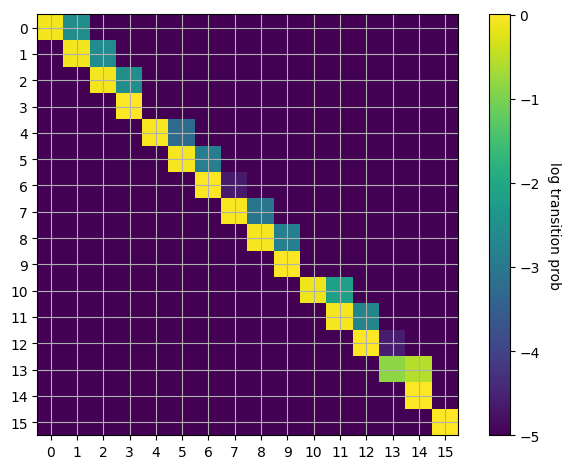

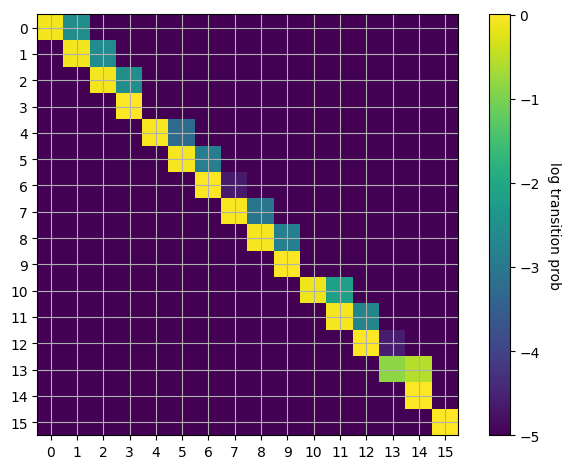

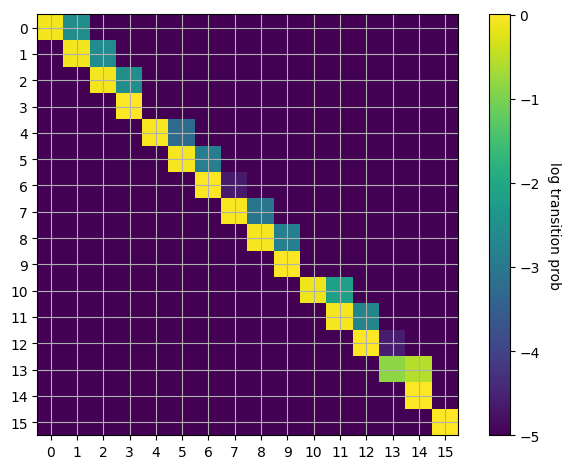

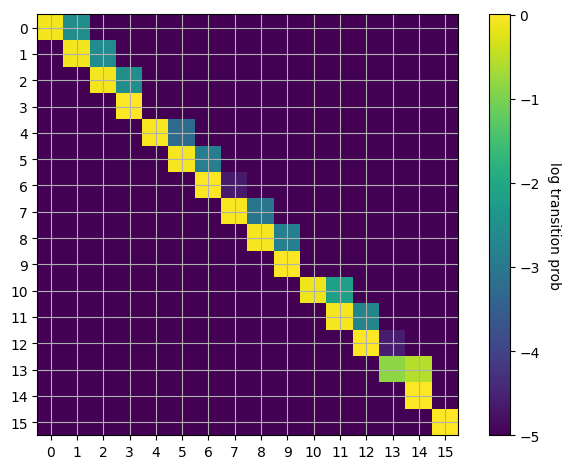

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-06-02 23:29:52.281 | INFO     |  Taking frame origins from demos.


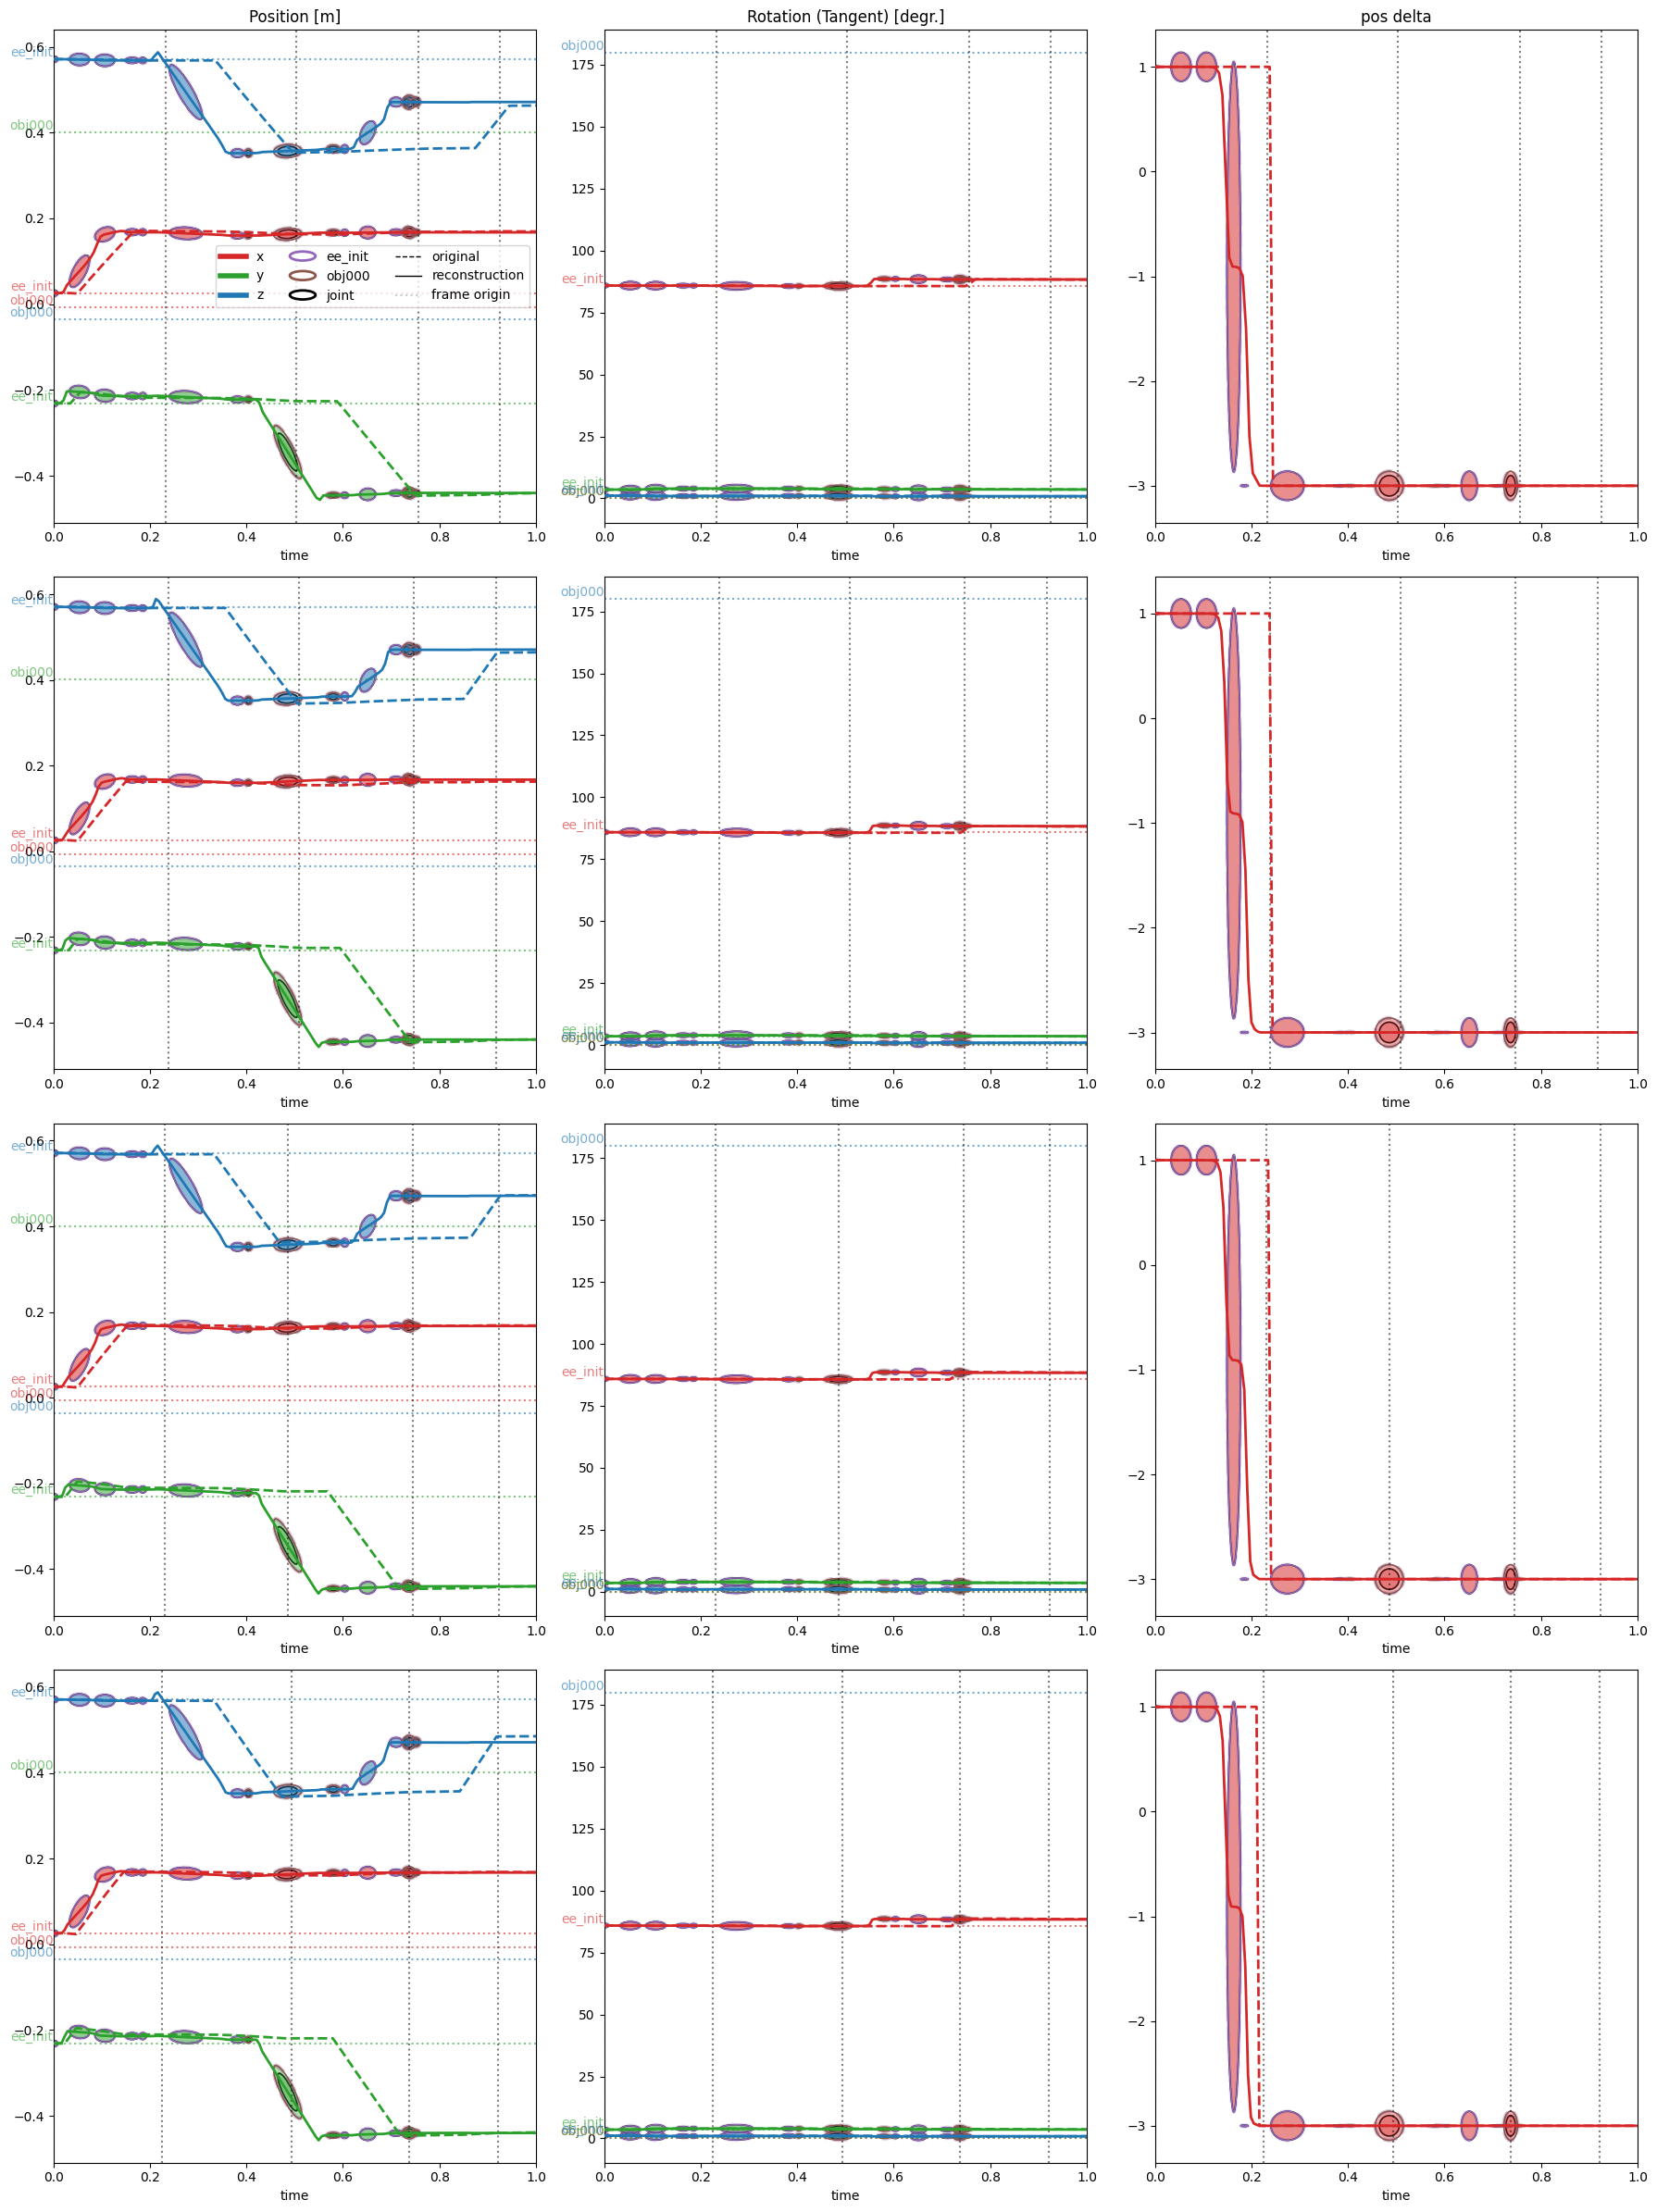

In [17]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=True,
    per_segment=False,
)

2025-06-02 23:30:16.416 | INFO     |  Taking frame origins from demos.


AttributeError: 'tuple' object has no attribute 'np_to_manifold_to_np'